In [40]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

import dlib
import os.path


In [59]:
class Align:
    def __init__(self, predictor_path):
        self.detector = dlib.get_frontal_face_detector()
        self.sp = dlib.shape_predictor(predictor_path)

    def align(self, rgbImg, imgDim=224):
        dets = self.detector(rgbImg, 1) 
        if len(dets) == 0:
            return

        faces = dlib.full_object_detections()
        for detection in dets:
            faces.append(self.sp(rgbImg, detection))

        images = dlib.get_face_chips(rgbImg, faces, size=imgDim)
        return np.array(images)

In [60]:
def load_img(path):
    img = cv2.imread(path, 1)
    img = img[..., ::-1]
    return img

In [61]:
def align_img(rgbImg, imgDim=96, pred_path='shape_predictor_5_face_landmarks.dat'):
    return Align(pred_path).align(rgbImg, imgDim)

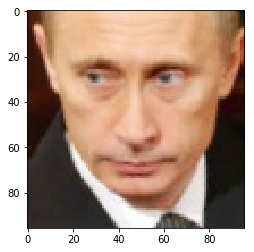

In [62]:
img = load_img('../images/Vladimir_Putin/Vladimir_Putin_0004.jpg')
align_faces = align_img(img)
plt.imshow(align_faces[0])

In [63]:
class IdentityData():
    def __init__(self, folder, name, file):
        self.folder = folder
        self.name = name
        self.file = file
        
    def image_path(self):
        return os.path.join(self.folder, self.name, self.file)
    
    def __repr__(self):
        return self.image_path()
    
def load_data(path):
    data = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                data.append(IdentityData(path, i, f))
                
    return np.array(data)

photos = load_data('../images/')
        

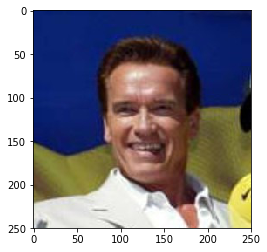

In [64]:
plt.imshow(load_img(photos[51].image_path()))

In [56]:
from model import create_model

nn4 = create_model()
nn4.load_weights('./weights/nn4.small2.v1.h5')

In [66]:
img1 = load_img(photos[0].image_path())
img1 = align_img(img1)[0]
img1 = (img1 / 255.).astype(np.float32)
embd1 = nn4.predict(np.expand_dims(img1, axis=0))[0]

In [69]:
img2 = load_img(photos[2].image_path())
img2 = align_img(img2)[0]
img2 = (img2 / 255.).astype(np.float32)
embd2 = nn4.predict(np.expand_dims(img2, axis=0))[0]

In [70]:
img30 = load_img(photos[30].image_path())
img30 = align_img(img30)[0]
img30 = (img30 / 255.).astype(np.float32)
embd30 = nn4.predict(np.expand_dims(img30, axis=0))[0]

In [102]:
embedded = np.zeros((photos.shape[0], 128))

for i, m in enumerate(photos):
    img = load_img(m.image_path())
    img = align_img(img)[0]
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4.predict(np.expand_dims(img, axis=0))[0]

In [94]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair_with_emb(idx1, idx2, emb1, emb2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(emb1, emb2):.2f}')
    plt.subplot(121)
    plt.imshow(load_img(photos[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_img(photos[idx2].image_path())); 
    
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_img(photos[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_img(photos[idx2].image_path())); 

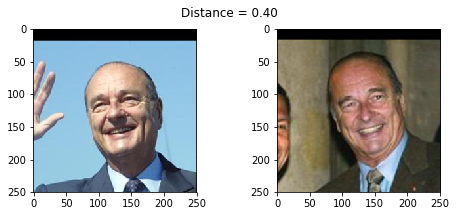

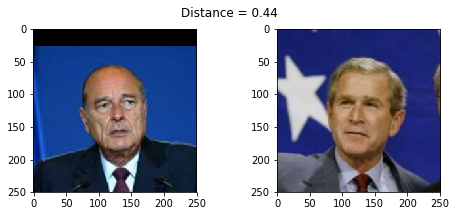

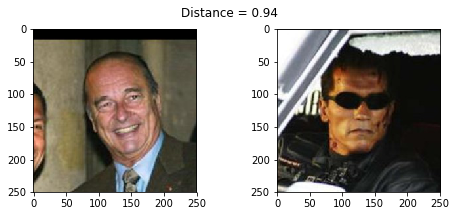

In [97]:
show_pair_with_emb(0, 2, embd1, embd2)
show_pair(3, 97)
show_pair(2, 50)

In [116]:
from krasserm_align import AlignDlib

alingment = AlignDlib('shape_predictor_68_face_landmarks.dat')

In [121]:
def krasserm_align(img):
    return alingment.align(96, img, alingment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [126]:
kr_emb = np.zeros((photos.shape[0], 128))

for i, m in enumerate(photos):
    img = load_img(m.image_path())
    img = krasserm_align(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    kr_emb[i] = nn4.predict(np.expand_dims(img, axis=0))[0]

In [127]:

def show_pair_krasserm(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(kr_emb[idx1], kr_emb[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_img(photos[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_img(photos[idx2].image_path())); 

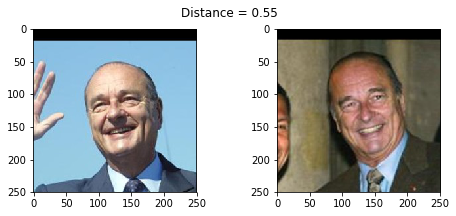

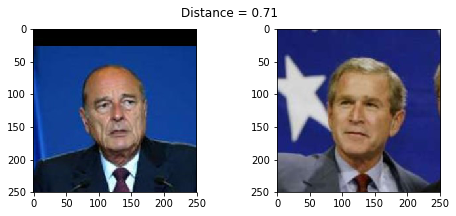

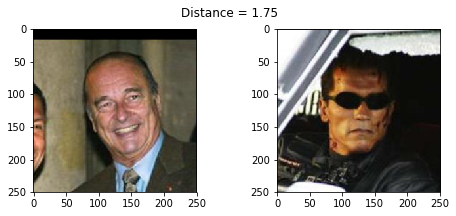

In [128]:
show_pair_krasserm(0, 2)
show_pair_krasserm(3, 97)
show_pair_krasserm(2, 50)